In [26]:
from io import open
import glob
import os
def findFiles(path):
    return glob.glob(path)
print(findFiles('data/data/names/*.txt'))

['data/data/names\\Arabic.txt', 'data/data/names\\Chinese.txt', 'data/data/names\\Czech.txt', 'data/data/names\\Dutch.txt', 'data/data/names\\English.txt', 'data/data/names\\French.txt', 'data/data/names\\German.txt', 'data/data/names\\Greek.txt', 'data/data/names\\Irish.txt', 'data/data/names\\Italian.txt', 'data/data/names\\Japanese.txt', 'data/data/names\\Korean.txt', 'data/data/names\\Polish.txt', 'data/data/names\\Portuguese.txt', 'data/data/names\\Russian.txt', 'data/data/names\\Scottish.txt', 'data/data/names\\Spanish.txt', 'data/data/names\\Vietnamese.txt']


In [27]:
import unicodedata
import string

In [28]:
all_letters=string.ascii_letters+" .,;'"  #大小写英文字母+.,;
n_letters=len(all_letters)
print(all_letters,n_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;' 57


In [29]:
#编码格式的转换
def unicodeToAscii(s):
    # NFC表示字符应该是整体组成(比如可能的话就使用单一编码)，而NFD表示字符应该分解为多个组合字符表示。
    return ''.join(c for c in unicodedata.normalize('NFD',s) 
                       #返回分配给字符 c 的常规类别为字符串
                      if unicodedata.category(c)!='Mn' and c in all_letters)
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [30]:
category_lines={}  #'语言类型':"姓名"
all_categories=[]  #语言类型1，语言类型2...
#读取name下的一个文件并按行分隔
def readLines(filename):
    lines=open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]
for filename in findFiles('data/data/names/*.txt'):
    #os.path.splitext:分离文件名与扩展名；默认返回(fname,fextension)元组
    category=os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines=readLines(filename)
    category_lines[category]=lines
n_categories=len(all_categories)

In [31]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [32]:
#Turning Names into Tensors

In [33]:
import torch
#找到55个字符对应的下标
def letterToIndex(letter):
    return all_letters.find(letter)
#将字符转化成one-hot向量[1,n_letters]
def letterToTensor(letter):
    tensor=torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)]=1
    return tensor

#再转换成[seq_length,1,n_letters]的Tensor
def lineToTensor(line):
    tensor=torch.zeros(len(line),1,n_letters)
    for li,letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)]=1
    return tensor
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [34]:
#RNN网络
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        self.hidden_size=hidden_size
        #i2h: Wx*X+Wxh*H----->W[X,H]
        self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
        #i2o:W*i2h
        self.i2o=nn.Linear(input_size+hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1)
    def forward(self,input,hidden):
        #print(input.size(),hidden.size())
        combined=torch.cat((input,hidden),1)
        #print(combined.size())
        hidden=self.i2h(combined)
        #print(hidden.size())
        output=self.i2o(combined)
        #print(output.size())
        output=self.softmax(output)
        return output,hidden
    def initHidden(self):
        return torch.zeros(1,self.hidden_size)
n_hidden=128
rnn=RNN(n_letters,n_hidden,n_categories)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [35]:
input=letterToTensor('A')   #[1,57]
hidden=torch.zeros(1,n_hidden) #[1,128]
output,next_hidden=rnn(input,hidden)

In [36]:
input=lineToTensor('Albert')
hidden=torch.zeros(1,n_hidden)
output,next_hidden=rnn(input[0],hidden)
print(output)

tensor([[-2.9737, -2.8385, -2.8709, -2.8820, -2.8553, -2.9367, -2.9076, -2.9417,
         -2.9328, -2.8588, -2.8977, -2.9480, -2.8422, -2.8799, -2.8922, -2.9181,
         -2.8147, -2.8523]], grad_fn=<LogSoftmaxBackward>)


In [37]:
#prepare data
def categoryFromOutput(output):
    #沿给定dim维度返回输入张量input中 k 个最大值。
    #如果不指定dim，则默认为input的最后一维。
    #返回：数字，对应的下标
    top_n,top_i=output.topk(1)
    category_i=top_i[0].item()
    return all_categories[category_i],category_i
print(categoryFromOutput(output))

('Spanish', 16)


In [38]:
import random
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]
def randomTrainingExample():
    category=randomChoice(all_categories)
    line=randomChoice(category_lines[category])
    category_tensor=torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor=lineToTensor(line) #[seq_len,1,57]
    return category,line,category_tensor,line_tensor
for i in range(10):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    print('category=',category,'/line=',line)

category= Irish /line= O'Doherty
category= Dutch /line= Pennders
category= Vietnamese /line= Luc
category= Scottish /line= Douglas
category= Polish /line= Grzeskiewicz
category= Korean /line= Gu
category= Irish /line= Sullivan
category= Spanish /line= Costa
category= Arabic /line= Bitar
category= Korean /line= Jeong


In [39]:
#training the network
#NLLLoss的结果就是把上面的输出与Label对应的那个值拿出来，再去掉负号，再求均值。
#CrossEntropyLoss就是把以上Softmax–Log–NLLLoss合并成一步
criterion=nn.NLLLoss()

In [40]:
#each loop for training will
    #Create input and target tensors
    # Create a zeroed initial hidden state
    # Read each letter in and
    # Keep hidden state for next letter
    # Compare final output to target
    # Back-propagate
    # Return the output and loss
learning_rate=0.005
def train(category_tensor,line_tensor):
    hidden=rnn.initHidden()
    
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)
    loss=criterion(output,category_tensor)
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(p.grad.data,alpha=-learning_rate)
    return output,loss.item()

In [50]:
import time
import math

n_iters=100000
print_every=5000
plot_every=1000

current_loss=0
all_loss=[]

def timeSince(since):
    now=time.time()
    s=now-since
    m=math.floor(s/60)
    s-=m*60
    return '%dm %ds'%(m,s)

start=time.time()
correct_total=0
for iter in range(1,n_iters+1):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    output,loss=train(category_tensor,line_tensor)
    current_loss+=loss
    guess,_=categoryFromOutput(output)
    if guess==category:
        correct_total+=1
    if iter %print_every==0:
        guess,guess_i=categoryFromOutput(output)
        correct="√" if guess==category else '×(%s)'%category
        print('%d %d%% (%s) %.4f %s / %s %s %.4f' %(iter,iter/n_iters*100,timeSince(start),loss,line,guess,correct,correct_total/print_every))
        correct_total=0
        
    if iter %plot_every==0:
        all_loss.append(current_loss/plot_every)
        current_loss=0

5000 5% (0m 13s) 0.7493 Luo / Chinese √ 0.5890
10000 10% (0m 29s) 2.4424 Stuart / French ×(English) 0.5946
15000 15% (0m 46s) 2.1404 Temko / Russian ×(Japanese) 0.5912
20000 20% (1m 5s) 0.9577 Trang / Vietnamese √ 0.5938
25000 25% (1m 20s) 1.4318 Hulme / English √ 0.6042
30000 30% (1m 36s) 3.3785 Neil / Korean ×(Irish) 0.5966
35000 35% (1m 52s) 2.3446 Nardo / Portuguese ×(Italian) 0.6076
40000 40% (2m 8s) 1.0363 Chehladze / Russian √ 0.6140
45000 45% (2m 23s) 3.9204 Kennedy / Dutch ×(Scottish) 0.5972
50000 50% (2m 39s) 0.2164 Tolbert / French √ 0.6140
55000 55% (2m 54s) 2.9725 Mcneil / Scottish ×(Irish) 0.6062
60000 60% (3m 11s) 0.2091 Jamieson / Scottish √ 0.6140
65000 65% (3m 27s) 2.9609 Pudel / Vietnamese ×(Czech) 0.6092
70000 70% (3m 44s) 5.8428 Boulos / Greek ×(Arabic) 0.6040
75000 75% (4m 0s) 0.2554 Havlatova / Czech √ 0.6206
80000 80% (4m 17s) 0.2540 Sauvage / French √ 0.6180
85000 85% (4m 34s) 0.7901 Ina / Japanese √ 0.6014
90000 90% (4m 50s) 2.1551 Milligan / Irish ×(English) 

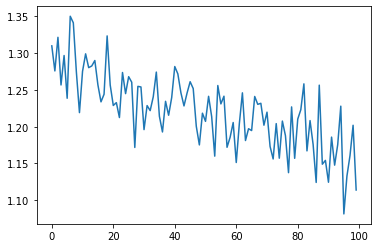

In [53]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_loss)
plt.show()

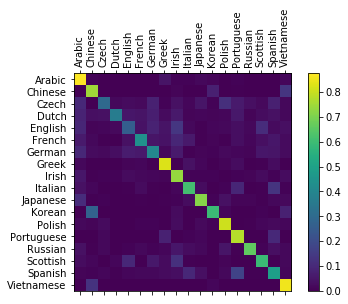

In [52]:
#evaluating

confusion=torch.zeros(n_categories,n_categories)
n_confusion=10000

def evaluate(line_tensor):
    hidden=rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)
    return output
for i in range(n_confusion):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    output=evaluate(line_tensor)
    guess,guess_i=categoryFromOutput(output)
    category_i=all_categories.index(category)
    confusion[category_i][guess_i]+=1

for i in range(n_categories):
    confusion[i]=confusion[i]/confusion[i].sum()
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(['']+all_categories,rotation=90)
ax.set_yticklabels(['']+all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [54]:
#对分类错误率较高的进行专门抽样训练
def randomTrainingExample_special():
    category='English'
    line=randomChoice(category_lines[category])
    category_tensor=torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor=lineToTensor(line) #[seq_len,1,57]
    return category,line,category_tensor,line_tensor

In [55]:
import time
import math

n_iters=10
print_every=5
plot_every=1

current_loss=0
all_loss=[]

def timeSince(since):
    now=time.time()
    s=now-since
    m=math.floor(s/60)
    s-=m*60
    return '%dm %ds'%(m,s)

start=time.time()
correct_total=0
for iter in range(1,n_iters+1):
    category,line,category_tensor,line_tensor=randomTrainingExample_special()
    output,loss=train(category_tensor,line_tensor)
    current_loss+=loss
    guess,_=categoryFromOutput(output)
    if guess==category:
        correct_total+=1
    if iter %print_every==0:
        guess,guess_i=categoryFromOutput(output)
        correct="√" if guess==category else '×(%s)'%category
        print('%d %d%% (%s) %.4f %s / %s %s %.4f' %(iter,iter/n_iters*100,timeSince(start),loss,line,guess,correct,correct_total/print_every))
        correct_total=0
        
    if iter %plot_every==0:
        all_loss.append(current_loss/plot_every)
        current_loss=0

5 50% (0m 0s) 1.1855 Lindop / English √ 0.2000
10 100% (0m 0s) 0.7091 Gunston / English √ 0.4000


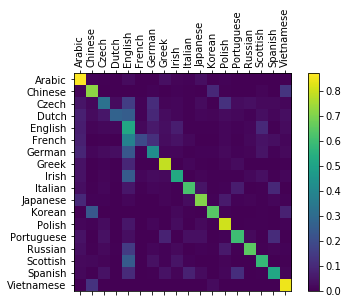

In [56]:
#evaluating

confusion=torch.zeros(n_categories,n_categories)
n_confusion=10000

def evaluate(line_tensor):
    hidden=rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)
    return output
for i in range(n_confusion):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    output=evaluate(line_tensor)
    guess,guess_i=categoryFromOutput(output)
    category_i=all_categories.index(category)
    confusion[category_i][guess_i]+=1

for i in range(n_categories):
    confusion[i]=confusion[i]/confusion[i].sum()
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels(['']+all_categories,rotation=90)
ax.set_yticklabels(['']+all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [19]:
def predict(input_line,n_predictions=3):
    print('\n> %s'%input_line)
    with torch.no_grad():
        output=evaluate(lineToTensor(input_line))
        topv,topi=output.topk(n_predictions,1,True)
        predictions=[]
        for i in range(n_predictions):
            value=topv[0][i].item()
            category_index=topi[0][i].item()
            print('(%.2f) %s'%(value,all_categories[category_index]))
            predictions.append([value,all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.77) Russian
(-0.77) Czech
(-3.23) English

> Jackson
(-0.51) Scottish
(-1.62) English
(-2.37) Russian

> Satoshi
(-1.08) Italian
(-1.88) Portuguese
(-1.99) Polish
